# Clustering

In [2]:
!nvidia-smi

Sat Jan 15 22:00:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   31C    P0    40W / 300W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import os
import time
from tqdm import tqdm
import numpy as np
import torch
from transformers import AutoConfig, AutoModel,AutoModelForPreTraining, AutoTokenizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
import unicodedata
import matplotlib


def get_embeddings(model_str, lyrics, embedding_fp=None):
    
    if model_str.endswith('.npy'):
        # already computed embeedings
        corpus_embeddings = np.load(model_str)
        
    else:
        # load model
        if os.path.isdir(model_str):
            config = AutoConfig.from_pretrained(f'{model_str}/config.json')
            model = AutoModel.from_config(config)
            model = AutoModel.from_pretrained(f'{model_str}/pytorch_model.bin',config=config)
            model.eval()
            model.cuda()
            tokenizer = AutoTokenizer.from_pretrained(model_str, use_fast=True)
        else:
            model = SentenceTransformer(model_str)

        # file to save embedding
        if embedding_fp is None:
            if os.path.isdir(model_str):
                embedding_fp = f"{os.path.split(model_str)[0]}_embeddings.pt"
            else:
                embedding_fp = f"{model_str}_embeddings.pt"
            embedding_fp = os.path.join("embeddings", embedding_fp)
            print(embedding_fp)

        # load or compute embeddings
        if os.path.exists(embedding_fp):
            print("loading already computed embeddings")
            corpus_embeddings = torch.load(embedding_fp)
            if torch.is_tensor(corpus_embeddings):
                corpus_embeddings = corpus_embeddings.cpu().data.numpy()
        else:
            start_time = time.time()
            if os.path.isdir(model_str):
                tokens = tokenizer.batch_encode_plus(
                    song_lyrics,
                    max_length = 512,
                    padding=True,
                    truncation=True
                )


                embed = []
                with torch.no_grad():
                    for i in tqdm(range(len( df_clean['lyrics']))):
                        tkin = tokens['input_ids'][i:i+1]
                        tkam = tokens['attention_mask'][i:i+1]

                        tkin = torch.tensor(tkin).cuda()
                        tkam = torch.tensor(tkam).cuda()

                        out = model(tkin,tkam)['last_hidden_state']
                        out = out.mean(1).cpu().numpy()

                        embed.append(out)
                corpus_embeddings = np.vstack(embed)

            else:
                corpus_embeddings = model.encode(song_lyrics)
                corpus_embeddings = corpus_embeddings.cpu().data.numpy()
            proc_time = time.time() - start_time
            print(f"Time for computing embeddings : {proc_time} seconds")
            print(f"{proc_time / num_sentences} seconds per song")
            torch.save(corpus_embeddings, embedding_fp)
        
    # normalize
    embedding_norms = np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)
    corpus_embeddings = corpus_embeddings /  embedding_norms


    return corpus_embeddings


def get_cluster_assignment(model_str, corpus_embeddings, n_cluster, affinity, linkage, clustering_fp=None, print_metrics=False):
    
    # file to save cluster assignment
    if clustering_fp is None:
        if os.path.isdir(model_str):
            clustering_fp = os.path.split(model_str)[0]
        elif model_str.endswith('.npy'):
            clustering_fp = os.path.basename(model_str).split(".")[0]
        else:
            clustering_fp = model_str
        clustering_fp = clustering_fp + f"_{n_cluster}clusters_affinity={affinity}_linkage={linkage}"
        clustering_fp = os.path.join("clustering", clustering_fp)
        clustering_fp_npz = clustering_fp + ".npz"
        print(clustering_fp_npz)
        # backwards compatibility
        clustering_fp_npy = clustering_fp + ".npy"
    else:
        assert clustering_fp.endswith('.npz')
        clustering_fp_npz = clustering_fp
    
    # load or compute cluster assignment
    ch = None
    db = None
    sh = None
            
    if os.path.exists(clustering_fp_npz):
        print("loading already computed cluster assignment")
        data = np.load(clustering_fp_npz)
        cluster_assignment = data["cluster_assignment"]
        ch = float(data["ch"])
        db = float(data["db"])
        sh = float(data["sh"])
        
    elif os.path.exists(clustering_fp_npy):
        print("loading already computed cluster assignment")
        cluster_assignment = np.load(clustering_fp_npy)
        
    else:
        print("start clustering")
        start_time = time.time()
        clustering_model = AgglomerativeClustering(n_clusters=n_cluster, affinity=affinity, linkage=linkage, distance_threshold=None)
        clustering_model.fit(corpus_embeddings)
        cluster_assignment = clustering_model.labels_
        proc_time = time.time() - start_time
        print(f"clustering time : {proc_time} seconds")
        
    if ch is None:
        # compute metrics
        print("computing metrics")
        ch = calinski_harabasz_score(corpus_embeddings, cluster_assignment)
        db = davies_bouldin_score(corpus_embeddings, cluster_assignment)
        sh = silhouette_score(corpus_embeddings, cluster_assignment)
        
        # save everything
        print(clustering_fp_npz)
        np.savez(
            clustering_fp_npz, 
            cluster_assignment=cluster_assignment, 
            ch=ch, db=db, sh=sh
        )
        
    if print_metrics:
        print("\ncalinski_harabasz_score : ", ch)
        print("davies_bouldin_score : ", db)
        print("silhouette_score : ", sh)
        
    return cluster_assignment, ch, db, sh


def print_clusters(df_fp, cluster_assignment, max_len=100, n_song=20, print_lyrics=False):
    
    df = pd.read_pickle(df_fp)
    song_lyrics = df['lyrics'].tolist()
    song_names = df['song_name'].tolist()
    song_artists = df['artist'].tolist()
    song_genres = df['genre'].tolist()
    
    clustered_sentences = {}
    clustered_songs = {}
    for sentence_id, cluster_id in enumerate(cluster_assignment):
        if cluster_id not in clustered_sentences:
            clustered_sentences[cluster_id] = []
            clustered_songs[cluster_id] = []

        clustered_sentences[cluster_id].append(song_lyrics[sentence_id][:max_len])
        clustered_songs[cluster_id].append(f"{song_names[sentence_id]} by {song_artists[sentence_id]} ({song_genres[sentence_id]})")

    if print_lyrics:
        for i, cluster in clustered_sentences.items():
            print("Cluster ", i+1)
            print(cluster)
            print("")

    ## print song, artist, genre
    for i, cluster in clustered_songs.items():
        print(f"Cluster {i+1}, {len(cluster)} songs")
        print(cluster[:n_song])
        print("")

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# compute / visualize cluster

In [3]:
# model = "mpnet-genre-valence-energy-danceability-finetuned/checkpoint-1041"
# model = "all-mpnet-base-v2"
model = "all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-1735"
# model = "mpnet-genre-valence-energy-danceability-genre-finetuned/checkpoint-1041"
# model = "all-mpnet-base-v2-finetuned-valence_quant2_unfrozen_base-checkpoint-1735/checkpoint-347"
# model = "all-mpnet-base-v2-finetuned-danceability_quant2_unfrozen_base-checkpoint-1735/checkpoint-694"
# model = "all-mpnet-base-v2-finetuned-energy_quant2_unfrozen_base-checkpoint-1388/checkpoint-1388"

# model = "embeddings/simsiam_mpnet.npy"
# model = "embeddings/simsiam_distilroberta.npy"

affinity = "cosine"   # “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”. If linkage is “ward”, only “euclidean” is accepted
linkage = "complete"   # {‘ward’, ‘complete’, ‘average’, ‘single’}, default=’ward’
n_clusters = 6

if model.endswith("npy"):
    df_fp = "df_clean_v3_13122021_py35.pkl"
else:
    df_fp = "df_clean_v4_14122021_py35.pkl"
df = pd.read_pickle(df_fp)
    
corpus_embeddings = get_embeddings(model, df['lyrics'].tolist())
cluster_assignment = get_cluster_assignment(
    model, corpus_embeddings, n_clusters, affinity, linkage, print_metrics=True
)[0]


print_clusters(df_fp, cluster_assignment, max_len=100, n_song=20, print_lyrics=False)

Some weights of the model checkpoint at all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-1735/pytorch_model.bin were not used when initializing MPNetModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing MPNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetModel were not initialized from the model checkpoint at all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-1735/pytorch_model.bin and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.

embeddings/all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735_embeddings.pt
loading already computed embeddings
clustering/all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735_6clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  518.893901188118
davies_bouldin_score :  4.632784071337288
silhouette_score :  0.03630077838897705
Cluster 4, 1655 songs
['thank u, next by Ariana Grande (dance pop)', 'SICKO MODE by Travis Scott (hip-hop/rap)', 'Mo Bamba by Sheck Wes (hip-hop/rap)', 'Money by Cardi B (hip-hop/rap)', 'Leave Me Alone by Flipp Dinero (hip-hop/rap)', 'Calling My Spirit by Kodak Black (hip-hop/rap)', 'Uproar by Lil Wayne (hip-hop/rap)', 'Pure Cocaine by Lil Baby (hip-hop/rap)', 'Testimony by Kodak Black (hip-hop/rap)', 'Envy Me by Calboy (hip-hop/rap)', 'Look Back at It by A Boogie Wit da Hoodie (hip-hop/rap)', 'Guardian angel by XXXTENTACION (hip-hop/rap)', 'I don’t let go by XXXTENTACION (hi

In [4]:
"""
"embeddings/simsiam_mpnet.npy" and "embeddings/simsiam_distilroberta.npy" seem to have nearly identical
embeddings, less so for simsiam_distilroberta

"""
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

n = 10
for i in range(n):
#     h = cosine_distances(corpus_embeddings[i][np.newaxis], corpus_embeddings)
    h = euclidean_distances(corpus_embeddings[i][np.newaxis], corpus_embeddings)
    print(np.argmin(h), h[:n])

0 [[0.        1.1171445 1.0177754 ... 1.1209708 1.103458  1.1143068]]
1 [[1.1171445e+00 2.1073424e-08 1.1822894e+00 ... 1.0214597e+00
  1.2848605e+00 1.2287821e+00]]
2 [[1.0177754  1.1822894  0.         ... 1.3500748  0.82240605 0.82816863]]
3 [[1.3531026 1.2850239 1.3049431 ... 1.3240258 1.2921038 1.3464386]]
4 [[1.2687802 1.2063764 1.3750361 ... 0.9818793 1.4218171 1.3892866]]
5 [[1.3976382 1.4239925 1.4631077 ... 1.3286586 1.4651046 1.4679759]]
6 [[1.4262477 1.4056594 1.3981291 ... 1.3539472 1.4449532 1.417395 ]]
7 [[1.363023  1.4275924 1.370545  ... 1.3643517 1.4036431 1.3820323]]
8 [[1.0089371 1.238565  0.7949955 ... 1.363838  0.8820729 0.8137873]]
9 [[1.3691969 1.4042118 1.405678  ... 1.2912331 1.3953125 1.3800164]]


# PCA for visualization

In [5]:
model = "all-mpnet-base-v2"
# model = "all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-1735"
# model = "mpnet-genre-valence-energy-danceability-genre-finetuned/checkpoint-1041"
# model = "all-mpnet-base-v2-finetuned-valence_quant2_unfrozen_base-checkpoint-1735/checkpoint-347"
# model = "all-mpnet-base-v2-finetuned-danceability_quant2_unfrozen_base-checkpoint-1735/checkpoint-694"
# model = "all-mpnet-base-v2-finetuned-energy_quant2_unfrozen_base-checkpoint-1388/checkpoint-1388"
# model = "embeddings/simsiam_mpnet.npy"
# model = "embeddings/simsiam_distilroberta.npy"

affinity = "cosine"   # “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”. If linkage is “ward”, only “euclidean” is accepted
linkage = "complete"   # {‘ward’, ‘complete’, ‘average’, ‘single’}, default=’ward’
n_clusters = 6

if model.endswith("npy"):
    df_fp = "df_clean_v3_13122021_py35.pkl"
else:
    df_fp = "df_clean_v4_14122021_py35.pkl"
df = pd.read_pickle(df_fp)
    
corpus_embeddings = get_embeddings(model, df['lyrics'].tolist())
cluster_assignment = get_cluster_assignment(
    model, corpus_embeddings, n_clusters, affinity, linkage, print_metrics=True
)[0]

pca = PCA(n_components=3)
pca_result = pca.fit_transform(X=corpus_embeddings)
print(pca_result.shape)

embeddings/all-mpnet-base-v2_embeddings.pt
loading already computed embeddings
clustering/all-mpnet-base-v2_6clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  134.9130692966871
davies_bouldin_score :  4.44597104141822
silhouette_score :  0.02176532708108425
(15863, 3)


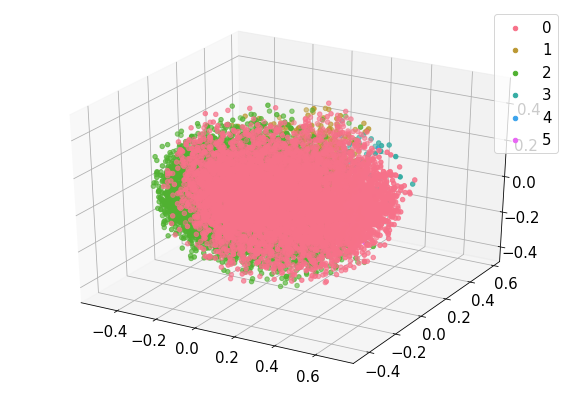

In [6]:
# for interactive display
# %matplotlib notebook   

FONTSIZE = 15
LINEWIDTH = 4
scale = "log"
matplotlib.rc('font', size=FONTSIZE)
matplotlib.rc('axes', titlesize=FONTSIZE)

fig = plt.figure(figsize=(10, 7))
cm = plt.get_cmap('gist_rainbow')
clrs = sns.color_palette('husl', n_colors=n_clusters)  # a list of RGB tuples
ax = plt.axes(projection ="3d")
start_idx = 0
for i in range(n_clusters):
    cluster_mask = cluster_assignment == i
    pca_cluster = pca_result[cluster_mask]
    ax.scatter3D(pca_cluster[:, 0], pca_cluster[:, 1], pca_cluster[:, 2], color=clrs[i], label=i)
plt.legend()

In [7]:
np.linalg.norm(corpus_embeddings, axis=1)

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

# compare approaches / embeddings

In [8]:
models = [
    "all-mpnet-base-v2",
    "all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-1735",
    "all-mpnet-base-v2-finetuned-valence_quant2_unfrozen_base-checkpoint-1735/checkpoint-347",
    "all-mpnet-base-v2-finetuned-danceability_quant2_unfrozen_base-checkpoint-1735/checkpoint-694",
    "all-mpnet-base-v2-finetuned-energy_quant2_unfrozen_base-checkpoint-1388/checkpoint-1388",
    
    "mpnet-genre-valence-finetuned/checkpoint-1041",
    "mpnet-genre-valence-energy-finetuned/checkpoint-694",
    "mpnet-genre-valence-energy-danceability-finetuned/checkpoint-1041",
    "mpnet-genre-valence-energy-danceability-genre-finetuned/checkpoint-1041",
    
    "all-distilroberta-v1",
    "all-distilroberta-v1-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-1735",
    # already computed embeddings form simsiam
    "embeddings/simsiam_mpnet.npy",
    "embeddings/simsiam_distilroberta.npy"
]

n_cluster_vals = np.arange(2, 16).astype(int)
# affinity = "euclidean"   # “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”. If linkage is “ward”, only “euclidean” is accepted
# linkage = "ward"   # {‘ward’, ‘complete’, ‘average’, ‘single’}, default=’ward’
affinity = "cosine"   # “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”. If linkage is “ward”, only “euclidean” is accepted
linkage = "complete"   # {‘ward’, ‘complete’, ‘average’, ‘single’}, default=’ward’


# initialize
ch = dict()
db = dict()
sh = dict()


# loop
start_time = time.time()
for _model in models:
    print(f"\n====== {_model} ======")
    ch[_model] = []
    db[_model] = []
    sh[_model] = []
    
    if _model.endswith("npy"):
        df_fp = "df_clean_v3_13122021_py35.pkl"
    else:
        df_fp = "df_clean_v4_14122021_py35.pkl"
    df = pd.read_pickle(df_fp)    
    _embeddings = get_embeddings(_model, df['lyrics'].tolist())
    print(_embeddings.shape)

    for _n_cluster in n_cluster_vals:

        print(f"\n---- {_n_cluster} CLUSTERS -----")
        
        cluster_assignment, _ch, _db, _sh = get_cluster_assignment(
            _model, _embeddings, _n_cluster, affinity, linkage, print_metrics=True
        )
        ch[_model].append(_ch)
        db[_model].append(_db)
        sh[_model].append(_sh)

proc_time = time.time() - start_time
print("\nproc time [min]:", proc_time / 60.)


====== all-mpnet-base-v2 ======
embeddings/all-mpnet-base-v2_embeddings.pt
loading already computed embeddings
(15863, 768)

---- 2 CLUSTERS -----
clustering/all-mpnet-base-v2_2clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  404.39006627390467
davies_bouldin_score :  6.208895855894102
silhouette_score :  0.024054449051618576

---- 3 CLUSTERS -----
clustering/all-mpnet-base-v2_3clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  212.1495269451406
davies_bouldin_score :  5.573343490601115
silhouette_score :  0.022935058921575546

---- 4 CLUSTERS -----
clustering/all-mpnet-base-v2_4clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  203.905671874813
davies_bouldin_score :  5.191068935355874
silhouette_score :  0.02280685119330883

---- 5 CLUSTERS -----
clustering/all-mpnet-base-v2_5cluster

Some weights of the model checkpoint at all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-1735/pytorch_model.bin were not used when initializing MPNetModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing MPNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetModel were not initialized from the model checkpoint at all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-1735/pytorch_model.bin and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.

embeddings/all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735_embeddings.pt
loading already computed embeddings
(15863, 768)

---- 2 CLUSTERS -----
clustering/all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735_2clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  271.3174539517887
davies_bouldin_score :  5.397660370440537
silhouette_score :  0.024898454546928406

---- 3 CLUSTERS -----
clustering/all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735_3clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  646.8947269721648
davies_bouldin_score :  5.119880792660673
silhouette_score :  0.03764889016747475

---- 4 CLUSTERS -----
clustering/all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735_4clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  702.691023

Some weights of the model checkpoint at all-mpnet-base-v2-finetuned-valence_quant2_unfrozen_base-checkpoint-1735/checkpoint-347/pytorch_model.bin were not used when initializing MPNetModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing MPNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetModel were not initialized from the model checkpoint at all-mpnet-base-v2-finetuned-valence_quant2_unfrozen_base-checkpoint-1735/checkpoint-347/pytorch_model.bin and are newly initialized: ['mpnet.pooler.dense.weight', 'mpn

embeddings/all-mpnet-base-v2-finetuned-valence_quant2_unfrozen_base-checkpoint-1735_embeddings.pt
loading already computed embeddings
(15863, 768)

---- 2 CLUSTERS -----
clustering/all-mpnet-base-v2-finetuned-valence_quant2_unfrozen_base-checkpoint-1735_2clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  1772.6524862427682
davies_bouldin_score :  2.8472858387365796
silhouette_score :  0.08902813494205475

---- 3 CLUSTERS -----
clustering/all-mpnet-base-v2-finetuned-valence_quant2_unfrozen_base-checkpoint-1735_3clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  1065.1299434922464
davies_bouldin_score :  4.690387510183378
silhouette_score :  0.045888084918260574

---- 4 CLUSTERS -----
clustering/all-mpnet-base-v2-finetuned-valence_quant2_unfrozen_base-checkpoint-1735_4clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

Some weights of the model checkpoint at all-mpnet-base-v2-finetuned-danceability_quant2_unfrozen_base-checkpoint-1735/checkpoint-694/pytorch_model.bin were not used when initializing MPNetModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing MPNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetModel were not initialized from the model checkpoint at all-mpnet-base-v2-finetuned-danceability_quant2_unfrozen_base-checkpoint-1735/checkpoint-694/pytorch_model.bin and are newly initialized: ['mpnet.pooler.dense.wei

embeddings/all-mpnet-base-v2-finetuned-danceability_quant2_unfrozen_base-checkpoint-1735_embeddings.pt
loading already computed embeddings
(15916, 768)

---- 2 CLUSTERS -----
clustering/all-mpnet-base-v2-finetuned-danceability_quant2_unfrozen_base-checkpoint-1735_2clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  1039.1187615045922
davies_bouldin_score :  3.7406768987553223
silhouette_score :  0.05508656054735184

---- 3 CLUSTERS -----
clustering/all-mpnet-base-v2-finetuned-danceability_quant2_unfrozen_base-checkpoint-1735_3clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  541.4362879396677
davies_bouldin_score :  4.403209245205159
silhouette_score :  0.05299536511301994

---- 4 CLUSTERS -----
clustering/all-mpnet-base-v2-finetuned-danceability_quant2_unfrozen_base-checkpoint-1735_4clusters_affinity=cosine_linkage=complete.npz
loading already computed 

Some weights of the model checkpoint at all-mpnet-base-v2-finetuned-energy_quant2_unfrozen_base-checkpoint-1388/checkpoint-1388/pytorch_model.bin were not used when initializing MPNetModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing MPNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetModel were not initialized from the model checkpoint at all-mpnet-base-v2-finetuned-energy_quant2_unfrozen_base-checkpoint-1388/checkpoint-1388/pytorch_model.bin and are newly initialized: ['mpnet.pooler.dense.weight', 'mpn

embeddings/all-mpnet-base-v2-finetuned-energy_quant2_unfrozen_base-checkpoint-1388_embeddings.pt
loading already computed embeddings
(15916, 768)

---- 2 CLUSTERS -----
clustering/all-mpnet-base-v2-finetuned-energy_quant2_unfrozen_base-checkpoint-1388_2clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  1376.8135671741313
davies_bouldin_score :  3.3203724657609306
silhouette_score :  0.07924165576696396

---- 3 CLUSTERS -----
clustering/all-mpnet-base-v2-finetuned-energy_quant2_unfrozen_base-checkpoint-1388_3clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  743.6973385028579
davies_bouldin_score :  3.7923241928281892
silhouette_score :  0.07794154435396194

---- 4 CLUSTERS -----
clustering/all-mpnet-base-v2-finetuned-energy_quant2_unfrozen_base-checkpoint-1388_4clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

cal

Some weights of the model checkpoint at mpnet-genre-valence-finetuned/checkpoint-1041/pytorch_model.bin were not used when initializing MPNetModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing MPNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetModel were not initialized from the model checkpoint at mpnet-genre-valence-finetuned/checkpoint-1041/pytorch_model.bin and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to

embeddings/mpnet-genre-valence-finetuned_embeddings.pt
loading already computed embeddings
(15863, 768)

---- 2 CLUSTERS -----
clustering/mpnet-genre-valence-finetuned_2clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  1025.922154128151
davies_bouldin_score :  3.866504468873835
silhouette_score :  0.06558395177125931

---- 3 CLUSTERS -----
clustering/mpnet-genre-valence-finetuned_3clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  966.3401812276509
davies_bouldin_score :  3.850513665782495
silhouette_score :  0.06273681670427322

---- 4 CLUSTERS -----
clustering/mpnet-genre-valence-finetuned_4clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  746.8667209225083
davies_bouldin_score :  4.49577226844492
silhouette_score :  0.04062958434224129

---- 5 CLUSTERS -----
clustering/mpnet-genre-va

Some weights of the model checkpoint at mpnet-genre-valence-energy-finetuned/checkpoint-694/pytorch_model.bin were not used when initializing MPNetModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing MPNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetModel were not initialized from the model checkpoint at mpnet-genre-valence-energy-finetuned/checkpoint-694/pytorch_model.bin and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-st

embeddings/mpnet-genre-valence-energy-finetuned_embeddings.pt
loading already computed embeddings
(15863, 768)

---- 2 CLUSTERS -----
clustering/mpnet-genre-valence-energy-finetuned_2clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  1450.3793822471298
davies_bouldin_score :  2.347120041185152
silhouette_score :  0.11196302622556686

---- 3 CLUSTERS -----
clustering/mpnet-genre-valence-energy-finetuned_3clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  906.9543788900742
davies_bouldin_score :  4.977039448185933
silhouette_score :  0.045605458319187164

---- 4 CLUSTERS -----
clustering/mpnet-genre-valence-energy-finetuned_4clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  708.1848016155254
davies_bouldin_score :  4.5575386033158125
silhouette_score :  0.03899243474006653

---- 5 CLUSTERS

Some weights of the model checkpoint at mpnet-genre-valence-energy-danceability-finetuned/checkpoint-1041/pytorch_model.bin were not used when initializing MPNetModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing MPNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetModel were not initialized from the model checkpoint at mpnet-genre-valence-energy-danceability-finetuned/checkpoint-1041/pytorch_model.bin and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably T

embeddings/mpnet-genre-valence-energy-danceability-finetuned_embeddings.pt
loading already computed embeddings
(15863, 768)

---- 2 CLUSTERS -----
clustering/mpnet-genre-valence-energy-danceability-finetuned_2clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  1375.696774059681
davies_bouldin_score :  2.586693392914555
silhouette_score :  0.09945189952850342

---- 3 CLUSTERS -----
clustering/mpnet-genre-valence-energy-danceability-finetuned_3clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  867.293052525637
davies_bouldin_score :  4.455305875481915
silhouette_score :  0.04845844954252243

---- 4 CLUSTERS -----
clustering/mpnet-genre-valence-energy-danceability-finetuned_4clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  652.4418072270249
davies_bouldin_score :  5.253938143420315
silhouet

Some weights of the model checkpoint at mpnet-genre-valence-energy-danceability-genre-finetuned/checkpoint-1041/pytorch_model.bin were not used when initializing MPNetModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing MPNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetModel were not initialized from the model checkpoint at mpnet-genre-valence-energy-danceability-genre-finetuned/checkpoint-1041/pytorch_model.bin and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You shoul

embeddings/mpnet-genre-valence-energy-danceability-genre-finetuned_embeddings.pt
loading already computed embeddings
(15863, 768)

---- 2 CLUSTERS -----
clustering/mpnet-genre-valence-energy-danceability-genre-finetuned_2clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  449.13125214254376
davies_bouldin_score :  5.920821875467341
silhouette_score :  0.026736166328191757

---- 3 CLUSTERS -----
clustering/mpnet-genre-valence-energy-danceability-genre-finetuned_3clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  612.9488937810507
davies_bouldin_score :  5.258228216021641
silhouette_score :  0.01665957272052765

---- 4 CLUSTERS -----
clustering/mpnet-genre-valence-energy-danceability-genre-finetuned_4clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  571.0680649229688
davies_bouldin_score : 

Some weights of the model checkpoint at all-distilroberta-v1-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-1735/pytorch_model.bin were not used when initializing RobertaModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at all-distilroberta-v1-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-1735/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'rob

embeddings/all-distilroberta-v1-finetuned-genre_unfrozen_base-checkpoint-1735_embeddings.pt
loading already computed embeddings
(15863, 768)

---- 2 CLUSTERS -----
clustering/all-distilroberta-v1-finetuned-genre_unfrozen_base-checkpoint-1735_2clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  450.32356252072384
davies_bouldin_score :  2.6350122502339928
silhouette_score :  0.05536874756217003

---- 3 CLUSTERS -----
clustering/all-distilroberta-v1-finetuned-genre_unfrozen_base-checkpoint-1735_3clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  388.6002617341484
davies_bouldin_score :  5.475096518271161
silhouette_score :  0.017006270587444305

---- 4 CLUSTERS -----
clustering/all-distilroberta-v1-finetuned-genre_unfrozen_base-checkpoint-1735_4clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score


calinski_harabasz_score :  4.031646241222003
davies_bouldin_score :  1.0001666518359216
silhouette_score :  0.9476451873779297

---- 3 CLUSTERS -----
clustering/simsiam_distilroberta_3clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  32.054975605411464
davies_bouldin_score :  1.0023334004479827
silhouette_score :  0.8516096472740173

---- 4 CLUSTERS -----
clustering/simsiam_distilroberta_4clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  12045.152769497696
davies_bouldin_score :  1.2238803195091428
silhouette_score :  0.4805580973625183

---- 5 CLUSTERS -----
clustering/simsiam_distilroberta_5clusters_affinity=cosine_linkage=complete.npz
loading already computed cluster assignment

calinski_harabasz_score :  9033.29920945832
davies_bouldin_score :  1.179501183203128
silhouette_score :  0.47986578941345215

---- 6 CLUSTERS -----
clustering/simsiam_dist

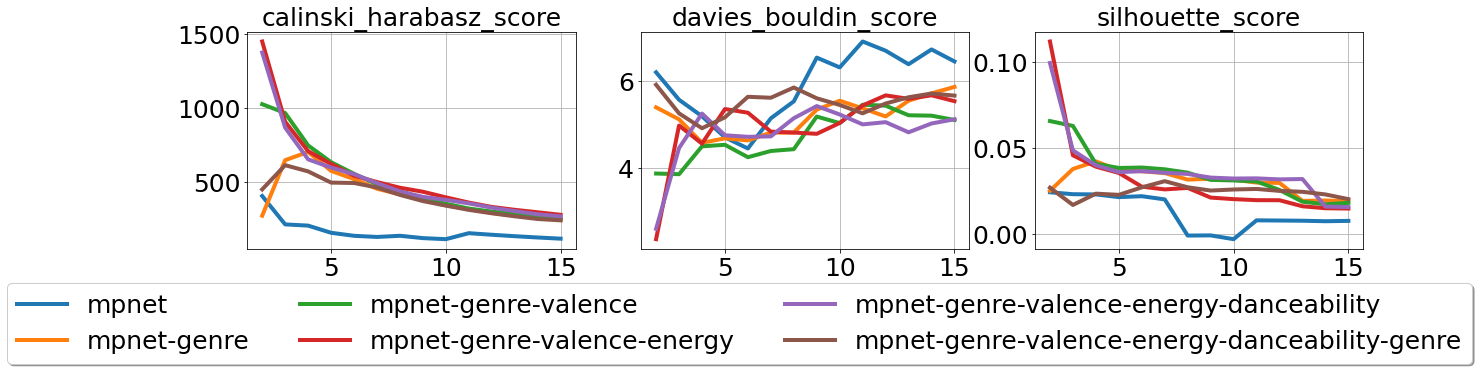

In [10]:
FONTSIZE = 25
LINEWIDTH = 4
scale = "linear"
matplotlib.rc('font', size=FONTSIZE)
matplotlib.rc('axes', titlesize=FONTSIZE)


f, ax = plt.subplots(1, 3, figsize=(20, 4))
model2label = {
    "all-mpnet-base-v2": "mpnet",
    "all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-1735": "mpnet-genre",
    
#     "all-mpnet-base-v2-finetuned-valence_quant2_unfrozen_base-checkpoint-1735/checkpoint-347": "mpnet-valence",
#     "all-mpnet-base-v2-finetuned-danceability_quant2_unfrozen_base-checkpoint-1735/checkpoint-694": "mpnet-danceability",
#     "all-mpnet-base-v2-finetuned-energy_quant2_unfrozen_base-checkpoint-1388/checkpoint-1388": "mpnet-energy",
    
    "mpnet-genre-valence-finetuned/checkpoint-1041": "mpnet-genre-valence",
    "mpnet-genre-valence-energy-finetuned/checkpoint-694": "mpnet-genre-valence-energy",
    "mpnet-genre-valence-energy-danceability-finetuned/checkpoint-1041": "mpnet-genre-valence-energy-danceability",
    "mpnet-genre-valence-energy-danceability-genre-finetuned/checkpoint-1041": "mpnet-genre-valence-energy-danceability-genre",
    
#     "all-distilroberta-v1": "distilroberta",
#     "all-distilroberta-v1-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-1735": "distilroberta-genre",
#     "embeddings/simsiam_mpnet.npy": "simsiam_mpnet",
#     "embeddings/simsiam_distilroberta.npy": "simsiam_distilroberta"
}

for _model in model2label:
    ax[0].plot(n_cluster_vals, ch[_model], label=model2label[_model], linewidth=LINEWIDTH)
    ax[0].set_title("calinski_harabasz_score")
    ax[0].set_yscale(scale)
    ax[0].grid(True)
    ax[1].plot(n_cluster_vals, db[_model], label=model2label[_model], linewidth=LINEWIDTH)
    ax[1].set_title("davies_bouldin_score")
    ax[1].set_yscale(scale)
    ax[1].grid(True)
    ax[2].plot(n_cluster_vals, sh[_model], label=model2label[_model], linewidth=LINEWIDTH)
    ax[2].set_title("silhouette_score")
    ax[2].grid(True)
#     ax[2].set_ylim([-1, 1])
#     ax[2].legend();
    ax[0].legend(loc='upper center', bbox_to_anchor=(1.5, -0.1), fancybox=True, shadow=True, ncol=3)

observations
- clearly two clusters for valence, danceability, and energy. makes sense as trained for binarry classification
- genre improved over base, bump at 4 clusters